### Table of Contents:

#### 1. Importing libraries and data
    Dataset from: 
    https://data.nasdaq.com/data/OPEC-organization-of-the-petroleum-exporting-countries
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the OPEC Crude Oil Prices

## 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'N3tn8rog-kyyNywcFbvM'

In [3]:
# Importing the Federal Reserve Economic Data "OPEC Crude Oil Price" variable.

data = quandl.get('OPEC/ORB')

In [4]:
data.head()

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [5]:
data.tail()

,Value
Date,
2023-03-06,84.59
2023-03-07,84.37
2023-03-08,82.12
2023-03-09,82.05
2023-03-10,80.72


In [6]:
data.shape

(5209, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

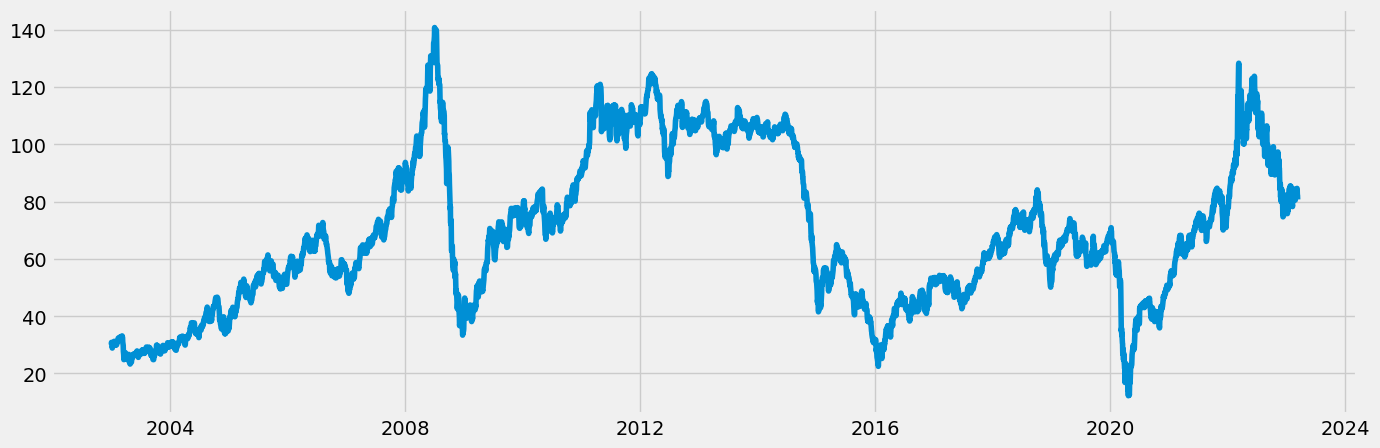

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

Data is from January 2 2003 to March 9 2023

## 2. Subsetting, wrangling, and cleaning time-series data

The data set has a reasonable time frame of 10 years , therefore i will not be reducing this data

In [10]:
# Reset index so that you can use the "Date" column as a filter
data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86


In [12]:
# there is some noise and would be best to summarize from daily to monthly
data_2=data_2.groupby(by=pd.Grouper(key='Date', freq='M', sort=True)).sum().reset_index()
data_2.set_index(keys=['Date'], drop=True, inplace=True)
data_2.head()

,Value
Date,
2003-01-31,667.40
2003-02-28,632.87
2003-03-31,618.24
2003-04-30,530.02
2003-05-31,563.85


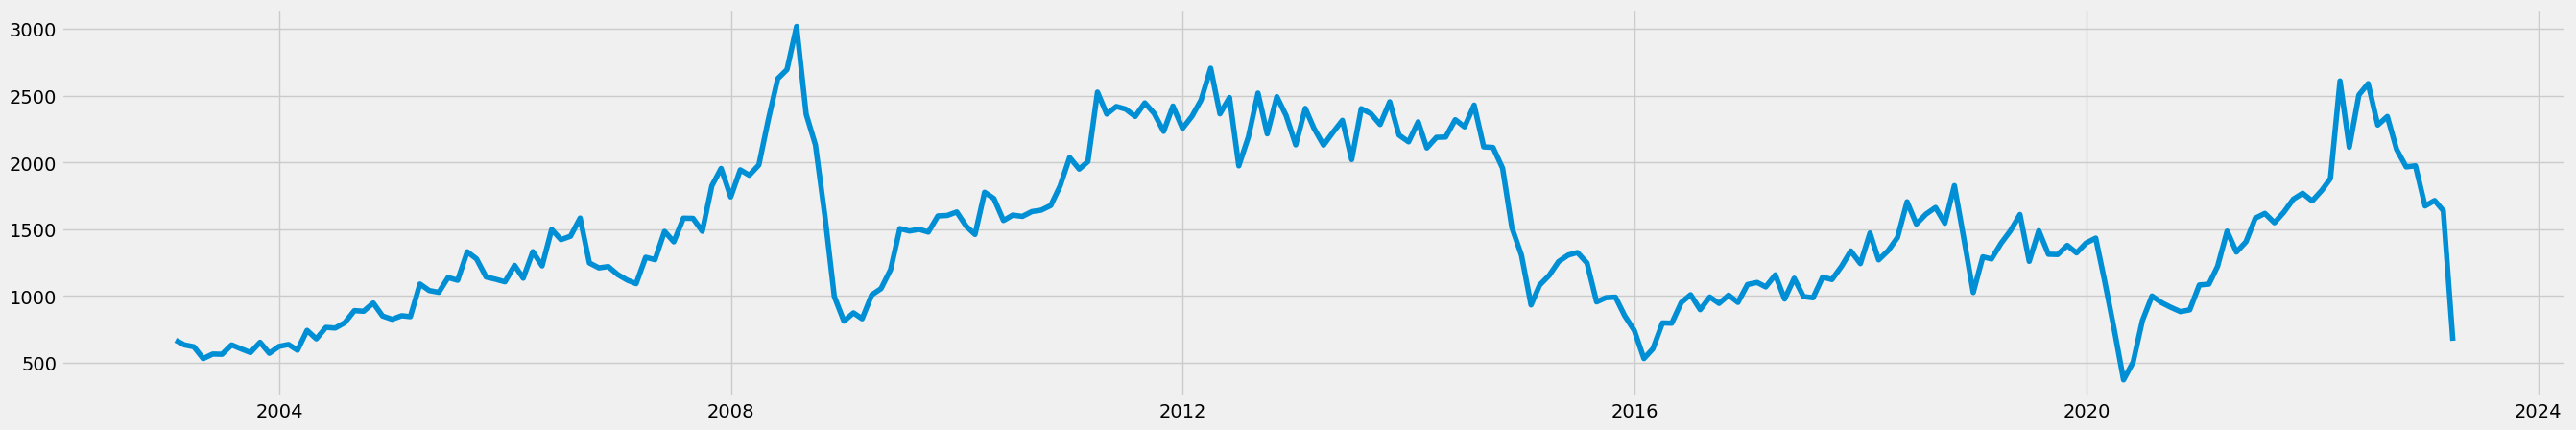

In [13]:
plt.figure(figsize=(30,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data_2)

In [14]:
# Check for missing values (you shouldn't have any)

data_2.isnull().sum()

Value    0
dtype: int64

In [15]:
# Check for duplicates

dups = data_2.duplicated()
dups.sum()

# No dups!

0

## 3. Time series analysis: decomposition

Looking at the graph I would recommend that multiplicative model might be more appropriate to capture the non-linearity 

In [16]:
# Decompose the time series using a multiplicative model

decomposition = sm.tsa.seasonal_decompose(data_2, model='multiplicative')

In [17]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

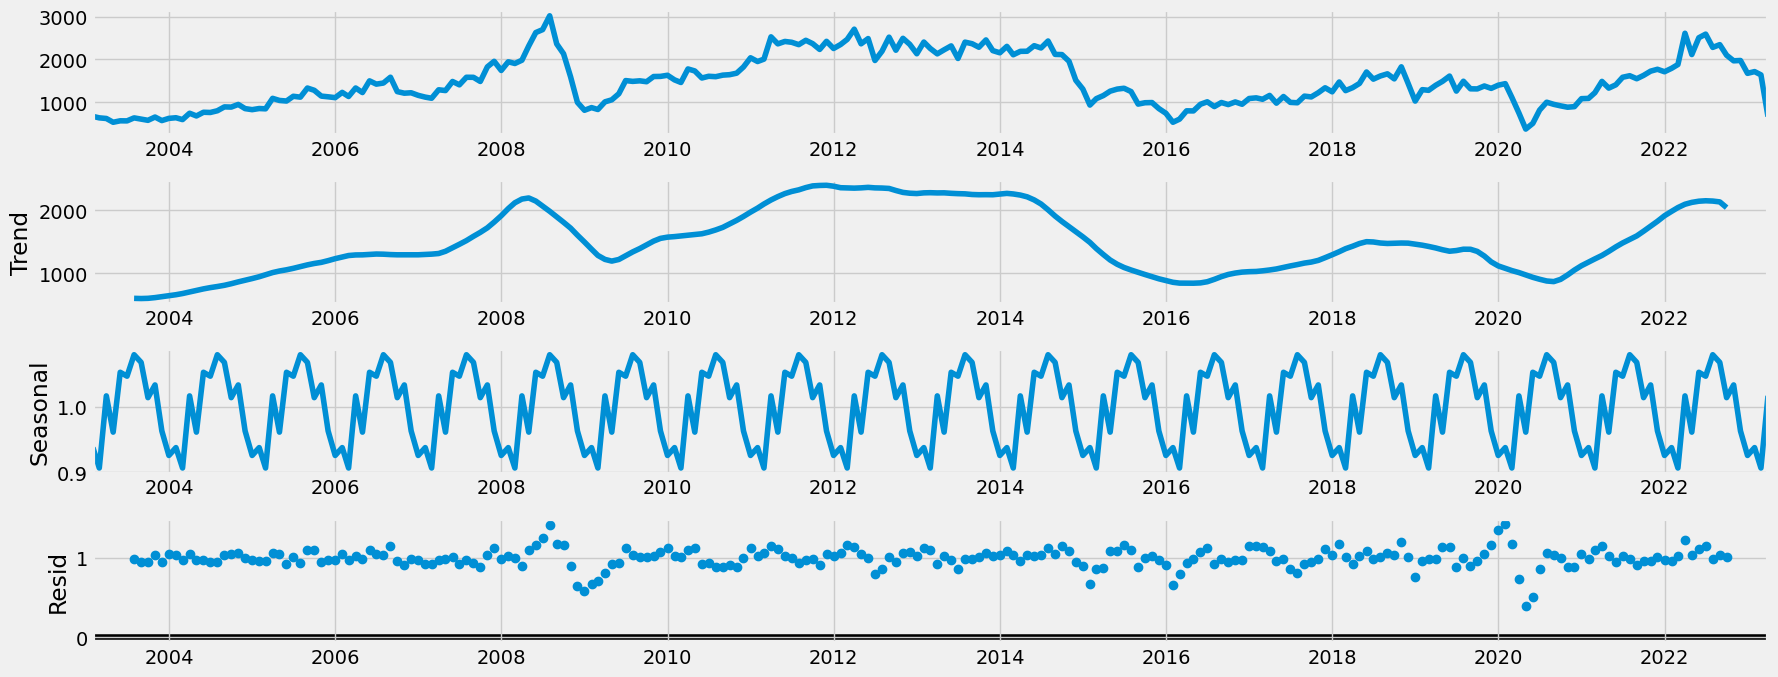

In [18]:
# Plot the separate components

decomposition.plot()
plt.show()

As assumed, the trend line follows the curvature of the original plot. The residue/noise is somewhat consistently on the same level except for 2 big dips: the first in 2008 most likely due to the global recession and again in 2020 which was due to COVID

## 4. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_2['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.516604
p-value                          0.111487
Number of Lags Used             13.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


The null hypothesis = the presence of a unit root 

The alternative hypothesis = there’s no unit root.

In this case at 5% percent the critical Value has a value of -2.874245. 
This is smaller than the test statistic, which is -2.516604.

This means that we can’t reject the null hypothesis and that there is a unit root in the data, and it's non-stationary

Also when cross referencing against the p-value, it confirms the above: P-value of 0.111487 is also larger than 0.05

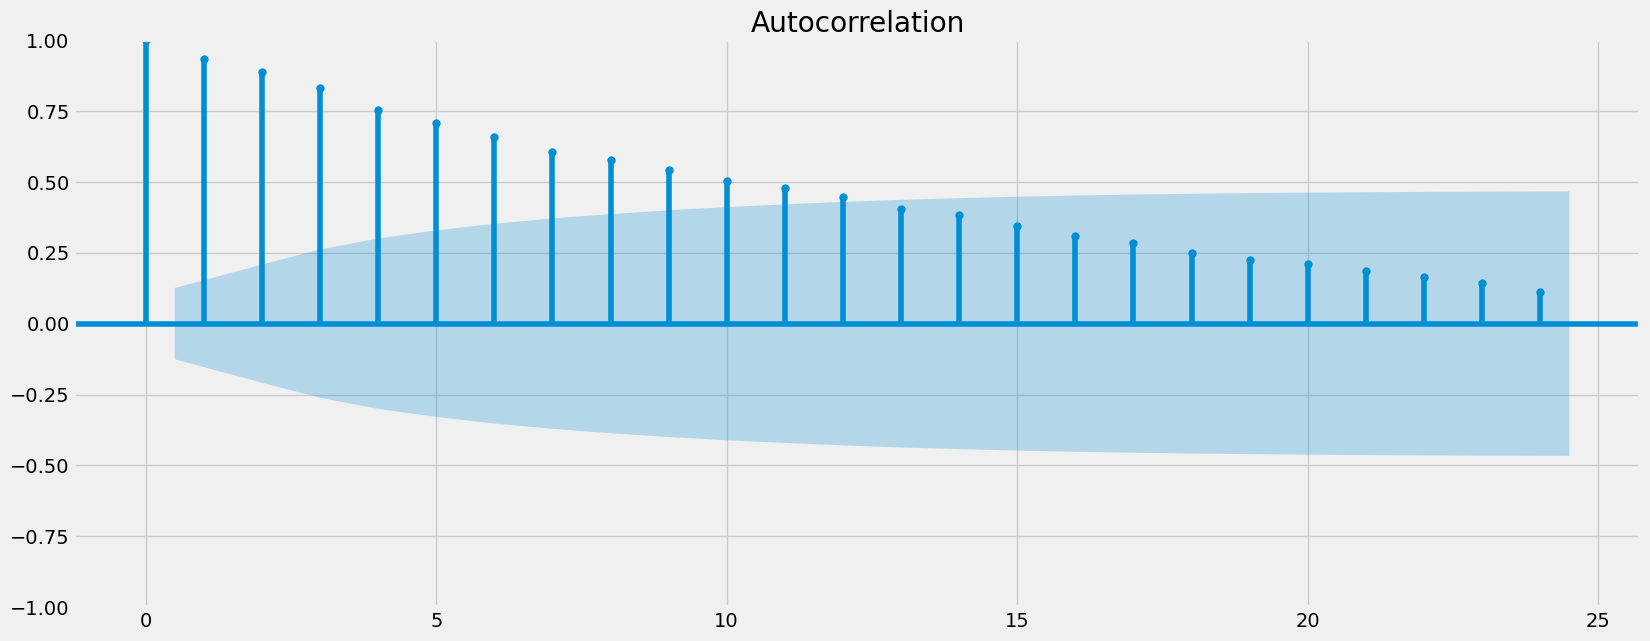

In [22]:
# Checking out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_2)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. 
There are 11 lags that are above the confidence interval confirming that they are significantly correlated with each other and therefore, non-stationary.

## 5. Stationarizing the OPEC Crude Oil Prices

### Differencing

In [23]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = data_2 - data_2.shift(1)

In [24]:
# Here, you remove the missing values that came about as a result of the differencing. 
data_diff.dropna(inplace = True) 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
Date,
2003-02-28,-34.53
2003-03-31,-14.63
2003-04-30,-88.22
2003-05-31,33.83
2003-06-30,-1.50


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

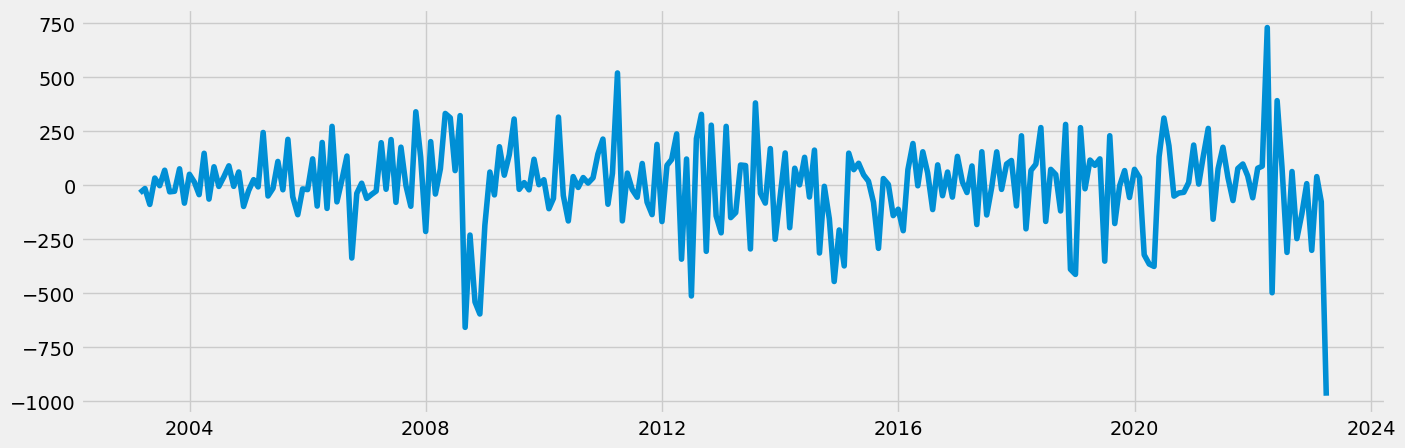

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.336172
p-value                          0.000384
Number of Lags Used             12.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


The test statistic is now smaller than all the critical levels which indicate that the data is now stationary.

This is also further confirmed with the p-value at 0.000384 which is smaller than 0.05

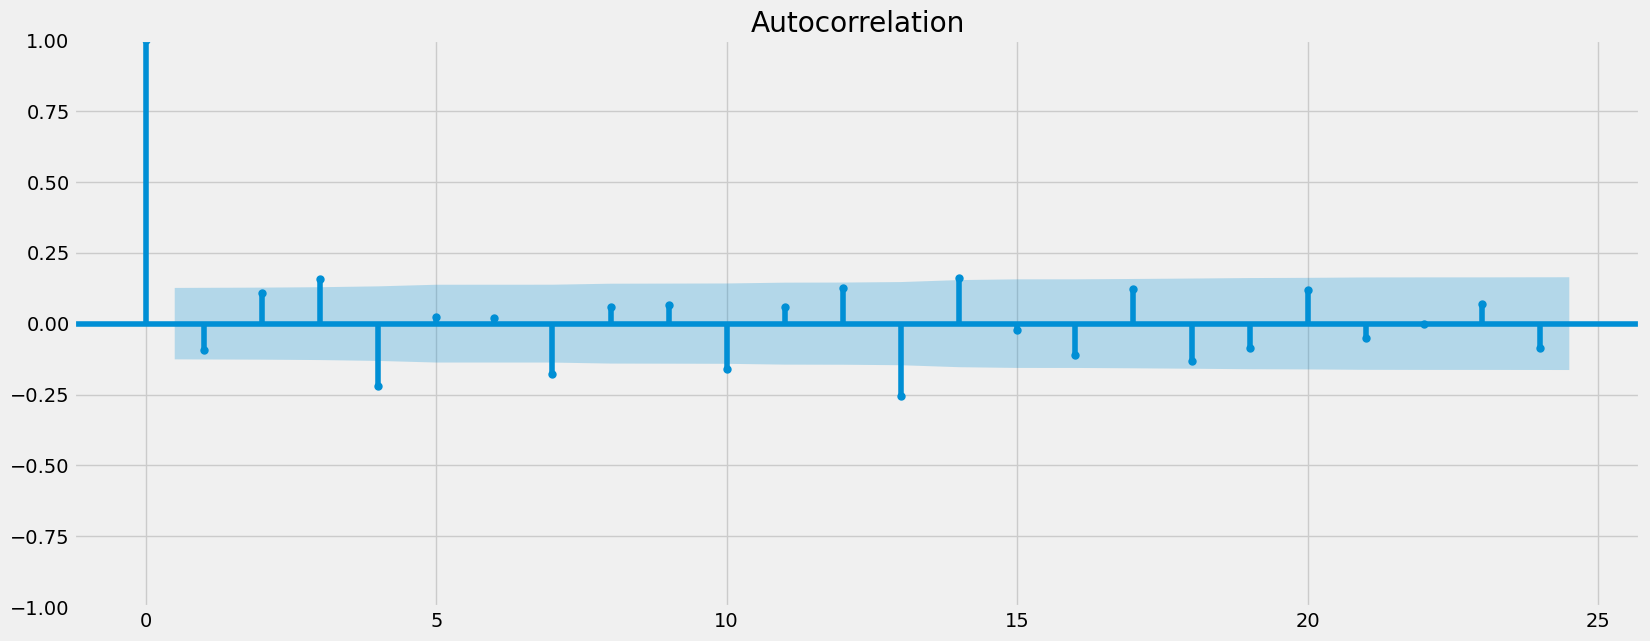

In [29]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has significantly improved  from 11 lags to now there only being 4. Althought the Dickey-Fuller test confirmed the data is now stationary the autocorrelation plot does not fully match. Another round of differentionation could be done to this data points. However, the general rule of the total lags being under 10 can be applied here and a second round is not necessary.